## Imports

In [ ]:
from google.colab import drive
import os

import cv2
import matplotlib.pyplot as plt

import numpy as np

from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.callbacks import ModelCheckpoint

## Load Pre-Processed Dataset

**Mount Drive and SetUp Paths**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "enter path here.."

/content/drive/MyDrive/Indonesia AI/Computer Vision/Final Project


In [ ]:
main_dir = "enter path here.."

org_images_train = os.path.join(main_dir, 'org_images_train')
org_images_val = os.path.join(main_dir, 'org_images_val')
anot_images_train = os.path.join(main_dir, 'anot_images_train')
anot_images_val = os.path.join(main_dir, 'anot_images_val')

**Load original images and annotations**

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

The Loaded images are having a dimension of 256x256, so we need to resize it to our desired dimensions (128x128).

In [ ]:
def load_ori_images(img_dir, dataset, samples):
  files = sorted(os.listdir(img_dir))
  for i in range(samples):
    img_path = os.path.join(img_dir, files[i])
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128,128))
    image = image/255 # normalize
    dataset.append(image)
  
  return np.array(dataset)

In [ ]:
def load_anotations(img_dir, dataset, samples):
  files = sorted(os.listdir(img_dir))
  for i in range(samples):
    img_path = os.path.join(img_dir, files[i])
    image = np.load(img_path) # file format in .npy
    image = cv2.resize(image, (128,128), interpolation = cv2.INTER_NEAREST) 
    # so ground truth will not change due to interpolation
    dataset.append(image) 

  return np.array(dataset)

Adjust the number of samples according to your hardware.

In [ ]:
x_train = load_ori_images(org_images_train, x_train, 1500)
y_train = load_anotations(anot_images_train, y_train, 1500)
x_test = load_ori_images(org_images_val, x_test, 350)
y_test = load_anotations(anot_images_val, y_test, 350)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1500, 128, 128)
(1500, 128, 128)
(350, 128, 128)
(350, 128, 128)


**Color the Annotations**

In [ ]:
class_map = {
    'unlabeled':(0, 0, 0),
    'sky':(70, 130, 180),
    'building':(70, 70, 70),
    'pole':(153, 153, 153),
    'road':(128, 64, 128),
    'sidewalk':(244, 35, 232),
    'vegetation':(107, 142, 35),
    'car':( 0, 0, 142),
    'person':(220, 20, 60),
    'traffic sign':(220, 220, 0)
}

In [ ]:
unique_colors = list(class_map.values())

In [ ]:
visualization = y_train[0].copy()
visualization = np.repeat(visualization.reshape(128, 128, 1), 3, axis=2) 
# copy channel 1 value into channel 2 and 3
visualization = visualization.reshape(-1, 3)
print(visualization.shape)

(16384, 3)


In [ ]:
for i in range(len(visualization)):
  visualization[i] = unique_colors[visualization[i][0]]
# replace index label with corresponding color

In [ ]:
visualization = visualization.reshape(128, 128, 3)

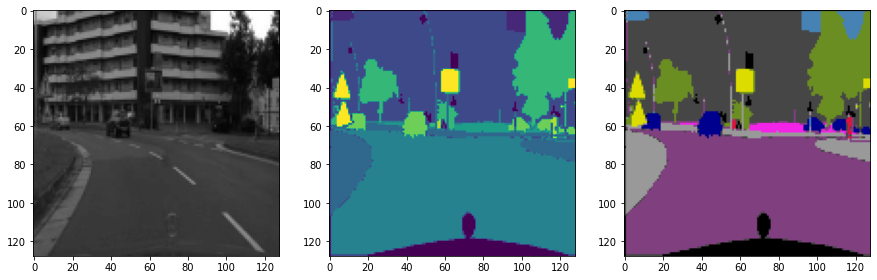

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(x_train[0], cmap='gray')
axes[1].imshow(y_train[0])
axes[2].imshow(visualization)

**One-Hot Encoding for Annotations**

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1500, 128, 128)
(1500, 128, 128, 10)
(350, 128, 128)
(350, 128, 128, 10)


In [ ]:
np.save('128 Image Size Experiment/x_test.npy', x_test)
np.save('128 Image Size Experiment/y_test.npy', y_test)

## UNet Architecture

In [ ]:
def unet():
  inputs = Input((128, 128, 1)) # adjust input dims, channel will be 1 bcs input image is in grayscale.


  c1 = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
  c1 = Conv2D(64, (3, 3), padding="same", activation="relu")(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(128, (3, 3), padding="same", activation="relu")(p1)
  c2 = Conv2D(128, (3, 3), padding="same", activation="relu")(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(256, (3, 3), padding="same", activation="relu")(p2)
  c3 = Conv2D(256, (3, 3), padding="same", activation="relu")(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(512, (3, 3), padding="same", activation="relu")(p3)
  c4 = Conv2D(512, (3, 3), padding="same", activation="relu")(c4)
  d4 = Dropout(0.2)(c4)
  p4 = MaxPooling2D((2, 2))(d4)


  c5 = Conv2D(1024, (3, 3), padding="same", activation="relu")(p4)
  c5 = Conv2D(1024, (3, 3), padding="same", activation="relu")(c5)
  d5 = Dropout(0.2)(c5)
  

  u6 = Conv2D(512, (2, 2), padding="same", activation="relu")(UpSampling2D((2, 2))(d5))
  m6 = concatenate([d4, u6], axis=3)
  c6 = Conv2D(512, (3, 3), padding="same", activation="relu")(m6)
  c6 = Conv2D(512, (3, 3), padding="same", activation="relu")(c6)

  u7 = Conv2D(256, (2, 2), padding="same", activation="relu")(UpSampling2D((2, 2))(c6))
  m7 = concatenate([c3, u7], axis=3)
  c7 = Conv2D(256, (3, 3), padding="same", activation="relu")(m7)
  c7 = Conv2D(256, (3, 3), padding="same", activation="relu")(c7)

  u8 = Conv2D(128, (2, 2), padding="same", activation="relu")(UpSampling2D((2, 2))(c7))
  m8 = concatenate([c2, u8], axis=3)
  c8 = Conv2D(128, (3, 3), padding="same", activation="relu")(m8)
  c8 = Conv2D(128, (3, 3), padding="same", activation="relu")(c8)

  u9 = Conv2D(64, (2, 2), padding="same", activation="relu")(UpSampling2D((2, 2))(c8))
  m9 = concatenate([c1, u9], axis=3)
  c9 = Conv2D(64, (3, 3), padding="same", activation="relu")(m9)
  c9 = Conv2D(64, (3, 3), padding="same", activation="relu")(c9)


  outputs = Conv2D(10, (1,1), activation="softmax")(c9) # 10 no. of kernels bcs 10 classes

  model = Model(inputs, outputs)
  return model

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

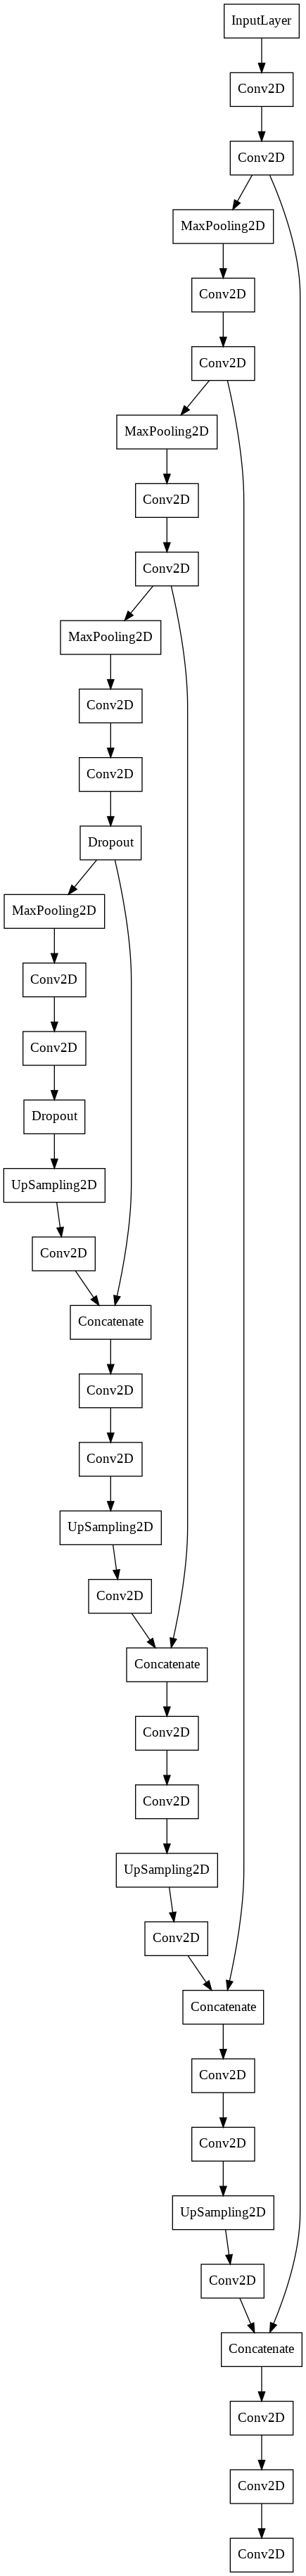

In [ ]:
plot_model(model, to_file="unet_architecture.png", rankdir='TB', 
                          show_layer_names=False)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training Model

In [ ]:
callback = ModelCheckpoint(filepath="128 Image Size Experiment/128_model.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

Lower batch size if runtime crash, so GPU not that heavy.

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=16, epochs=40, callbacks=[callback])

Epoch 1/40
94/94 [==============================] - ETA: 0s - loss: 1.6628 - accuracy: 0.4392
Epoch 1: val_accuracy improved from -inf to 0.62321, saving model to 128_model.h5
94/94 [==============================] - 57s 469ms/step - loss: 1.6628 - accuracy: 0.4392 - val_loss: 1.1402 - val_accuracy: 0.6232
Epoch 2/40
94/94 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.6506
Epoch 2: val_accuracy did not improve from 0.62321
94/94 [==============================] - 26s 274ms/step - loss: 1.0212 - accuracy: 0.6506 - val_loss: 1.1250 - val_accuracy: 0.6215
Epoch 3/40
94/94 [==============================] - ETA: 0s - loss: 0.9284 - accuracy: 0.6860
Epoch 3: val_accuracy improved from 0.62321 to 0.66282, saving model to 128_model.h5
94/94 [==============================] - 31s 332ms/step - loss: 0.9284 - accuracy: 0.6860 - val_loss: 1.0079 - val_accuracy: 0.6628
Epoch 4/40
94/94 [==============================] - ETA: 0s - loss: 0.8850 - accuracy: 0.7001
Epoch 4: v

## Model Evaluation

Plot Learning Curves

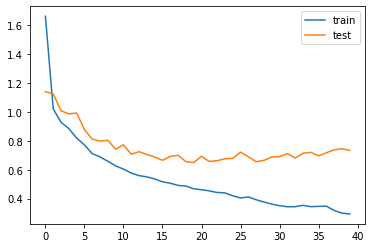

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig("128 Image Size Experiment/128 Loss Graph")
plt.show()

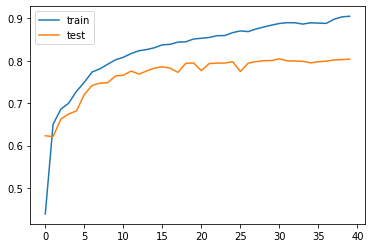

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.savefig("128 Image Size Experiment/128 Accuracy Graph")
plt.show()